In [1]:
import numpy as np
import torch
import torchani
import os
import math
import torch.utils.tensorboard
import tqdm
import pickle

import matplotlib
import matplotlib.pyplot as plt
from sys import getsizeof
import h5py

In [2]:
def load_pickle():
    f = open('model_config', 'rb')     
    cfg = pickle.load(f)
    f.close()
    return cfg

In [3]:
cfg = load_pickle()

In [4]:
device = 'cpu'

In [5]:
Rcr = 5.2000e+00
Rca = 3.5000e+00
EtaR = torch.tensor([1.6000000e+01], device=device)
ShfR = torch.tensor([9.0000000e-01, 1.1687500e+00, 1.4375000e+00, 1.7062500e+00, 1.9750000e+00, 2.2437500e+00, 2.5125000e+00, 2.7812500e+00, 3.0500000e+00, 3.3187500e+00, 3.5875000e+00, 3.8562500e+00, 4.1250000e+00, 4.3937500e+00, 4.6625000e+00, 4.9312500e+00], device=device)
Zeta = torch.tensor([3.2000000e+01], device=device)
ShfZ = torch.tensor([1.9634954e-01, 5.8904862e-01, 9.8174770e-01, 1.3744468e+00, 1.7671459e+00, 2.1598449e+00, 2.5525440e+00, 2.9452431e+00], device=device)
EtaA = torch.tensor([8.0000000e+00], device=device)
ShfA = torch.tensor([9.0000000e-01, 1.5500000e+00, 2.2000000e+00, 2.8500000e+00], device=device)
species_order = ['H', 'C', 'N', 'O']
num_species = len(species_order)
aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)
energy_shifter = torchani.utils.EnergyShifter(None)

In [6]:
aev_dim = aev_computer.aev_length

H_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 160),
    torch.nn.CELU(0.1),
    torch.nn.Linear(160, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

C_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 144),
    torch.nn.CELU(0.1),
    torch.nn.Linear(144, 112),
    torch.nn.CELU(0.1),
    torch.nn.Linear(112, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

N_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 112),
    torch.nn.CELU(0.1),
    torch.nn.Linear(112, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

O_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 112),
    torch.nn.CELU(0.1),
    torch.nn.Linear(112, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

nn = torchani.ANIModel([H_network, C_network, N_network, O_network])

In [7]:
model = torchani.nn.Sequential(aev_computer, nn).to(device)

In [8]:
latest_checkpoint = 'latest.pt'

In [9]:
if os.path.isfile(latest_checkpoint):
    checkpoint = torch.load(latest_checkpoint)
    nn.load_state_dict(checkpoint['nn'])

## Importing testing data

In [10]:
try:
    path = os.path.dirname(os.path.realpath(__file__))
except NameError:
    path = os.getcwd()
data_path = os.path.join(path, cfg['datasets_path'])

In [11]:
print(data_path)

/home/shaunak/Non_Research/sem8/ML4NS/proj/models/4_TorchANI_model/../../datasets/benzene_old_dft.npz


In [12]:
molecule = np.load(data_path)

In [13]:
species_map = {
    6 : "C".encode("utf-8"),
    1 : "H".encode("utf-8"),
    8 : "O".encode("utf-8"),
    7 : "N".encode("utf-8"),
}
mult = 627.5094738898777

In [14]:
species = list(map(lambda x:species_map[x], molecule['z']))

In [15]:
print(species)

[b'C', b'C', b'C', b'C', b'C', b'C', b'H', b'H', b'H', b'H', b'H', b'H']


In [16]:
new_data_file = os.path.join(path, 'tmp_testing.h5')
h5_file = h5py.File(new_data_file, 'w')

In [17]:
molecule_name = cfg['name']

In [18]:
if molecule_name not in h5_file:
    b = h5_file.create_group(molecule_name)
else:
    b = h5_file[molecule_name]

In [19]:
name = "test"

In [20]:
init, last = cfg['testing']
last = 40000
print(init, last)

30000 40000


In [21]:
if name not in b:
    sub_group = b.create_group(name)
else:
    sub_group = b[name]

if "coordinates" not in sub_group:
    sub_group.create_dataset("coordinates", data = molecule['R'][init:last])
if "energies" not in sub_group:
    sub_group.create_dataset("energies", data = molecule['E'][init:last].flatten() / mult) 
if "species" not in sub_group:
    sub_group.create_dataset("species", data = species)

In [22]:
print("Done with writing to temporary h5 file : ")
h5_file.close()

Done with writing to temporary h5 file : 


In [23]:
data = torchani.data.load(new_data_file)

## Loading model Parameters

In [24]:
species_order = ['H', 'C', 'N', 'O']
energy_shifter = torchani.utils.EnergyShifter(None)

In [25]:
p = data.subtract_self_energies(energy_shifter, species_order).species_to_indices(species_order)

In [29]:
h = p.collate(last - init).cache()

In [30]:
g = next(iter(h))
species = g['species']
coordinates = g['coordinates'].float()
true_energies = g['energies'].float()

In [32]:
print(species.shape)
print(coordinates.shape)

torch.Size([10000, 12])
torch.Size([10000, 12, 3])


In [33]:
_, predicted_energies = model((species, coordinates))

In [35]:
y_hat = true_energies.cpu().detach().numpy()
y = predicted_energies.cpu().detach().numpy()

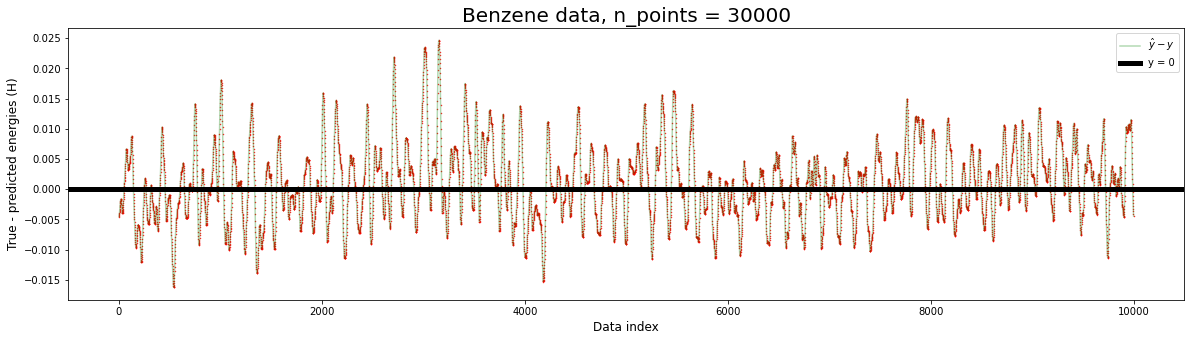

In [41]:
fig = plt.figure(figsize = (20, 5))
diff = y_hat - y
x = np.arange(diff.shape[0])
plt.plot(diff, alpha = 0.3, color = 'green', label = r'$\hat{y} - y$')
plt.scatter(x, diff, color='red', s = 0.2)
plt.axhline(y = 0, color='black', linewidth = 5, label = "y = 0")
plt.title("{} data, n_points = {}".format(cfg['name'], cfg['batches'][-1]), fontsize = 20)
plt.xlabel('Data index', fontsize = 12)
plt.ylabel('True - predicted energies (H)', fontsize = 12)
plt.legend()
plt.savefig('Loss data')